# Tutorial: Create a improvised RAG Piepline with Embedders using Haystack


## Installation

Install Haystack 2.0 using `pip`. Its enough to run it only once.

In [1]:
# Run it for the first time alone
# %%bash

# !pip install haystack-ai --upgrade

## Import necessary libraries


In [2]:
import os
import requests
from getpass import getpass

from haystack import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack.components.embedders import OpenAITextEmbedder, OpenAIDocumentEmbedder
from haystack.components.retrievers.in_memory import (
    InMemoryEmbeddingRetriever,
)

from haystack import Pipeline

/Users/apple/Documents/haystack-book/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/apple/Documents/haystack-book/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gathering data

For this example we will make use of [The Meal DB's API](https://www.themealdb.com/api.php). This provides a list of dishes and associated metadata. We make use of the required metadata and store those in the documents. Instead of collecting all the dishes we just get the dishes on the starting letter. Currently it's hard-coded to `p` but can be modified based on your interest.

In [3]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")
document_store_with_embedded_data = InMemoryDocumentStore(
    embedding_similarity_function="cosine"
)

baseURL = "https://www.themealdb.com/api/json/v1/1/search.php?f="
# alphabet = input("Enter your favourite alphabet: ")
alphabet = 'p'

# To handle user input
if len(alphabet) > 0:
    alphabet = alphabet[0]

data = requests.get(url=baseURL + alphabet)
data = data.json()

## Creating Documents

After fetching the data in `json` format, we convert it into [`Documents`](https://github.com/deepset-ai/haystack/blob/main/haystack/dataclasses/document.py#L48) for further usage.

In [4]:
documents = []

for i in range(len(data["meals"])):
    title = data["meals"][i]["strMeal"]
    instructions = data["meals"][i]["strInstructions"]

    documents.append(
        Document(
            content="Title: " + title + "\nMaking Instructions: " + instructions,
            meta={
                "cuisine": data["meals"][i]["strCategory"]
                + " "
                + data["meals"][i]["strArea"],
                "url": data["meals"][i]["strYoutube"],
            },
        )
    )

Get the OpenAI key from [here](https://platform.openai.com).

In [5]:
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key: ")

### Embedding & Storing the documents

We create a [In Memory Document Store](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore) and append the documents inside. A document store is nothing but a list of Documents grouped under a common name and avaiable to retrieve the closest match. `In-Memory` refers to making use of local system's memory compared to any external document store.

In [6]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")
document_embedder = OpenAIDocumentEmbedder()
documents_with_embeddings = document_embedder.run(documents=documents)["documents"]
print("Total of", document_store.write_documents(documents_with_embeddings), "appended.")

Calculating embeddings: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]

Total of 26 appended.


## Query Pipeline

We create a haystack [pipeline](https://docs.haystack.deepset.ai/docs/pipelines) to query the user's question and retrieve the closest matches based on [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).
A pipeline consists of various [components](https://docs.haystack.deepset.ai/docs/creating-pipelines#2-initialize-components) connected together.

Then we need to provide the links between the components which create the flow of the pipeline. We create a alias name for the pipeline component so that it becomes easy to address them further.

In [7]:
query_retrieval_pipeline = Pipeline()

text_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k=3)

query_retrieval_pipeline.add_component("text_embedder", text_embedder)
query_retrieval_pipeline.add_component("retriever", retriever)

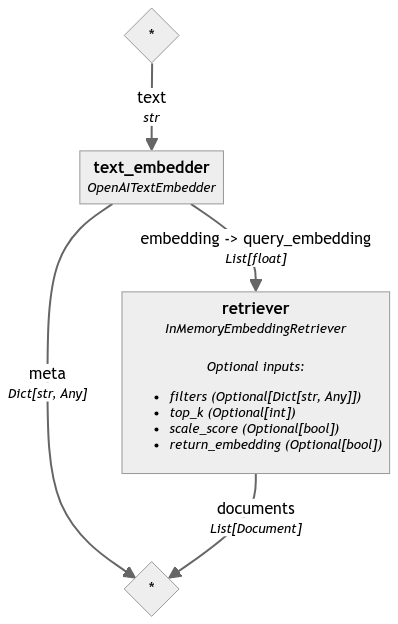

In [8]:
query_retrieval_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

## Output

To run the pipeline we pass the `user_input` as a dictionary. If there are multiple inputs we use the alias name and pass the input based on the input type.

Since this retrieves the list of documents we print the `top_k` here 3, documents that are nearest to the users query.

In [13]:
query = input("Enter the question: ")

print("For the question:", query, "?")
result = query_retrieval_pipeline.run(
    {
        "text_embedder": {"text": query},
    }
)

print("Retriever with Embeddings Results:\n")
for doc in result["retriever"]["documents"]:
    print(doc)
    print()

For the question: What are the top Italian cuisine ?
Retriever with Embeddings Results:

Document(id=b2f744c2cd7293aad20db71155d27d2c459c1d07899fcb3da50eddcd29f51cd3, content: 'Title: Pilchard puttanesca
Making Instructions: Cook the pasta following pack instructions. Heat the...', meta: {'cuisine': 'Pasta Italian', 'url': 'https://www.youtube.com/watch?v=wqZzLAPmr9k'}, score: 0.7847941595964654)

Document(id=ff02af8efee8ac7029e43a116185b311c0bc7cf39defe5696d5075e85675a3f0, content: 'Title: Pizza Express Margherita
Making Instructions: 1 Preheat the oven to 230°C.

2 Add the sugar...', meta: {'cuisine': 'Miscellaneous Italian', 'url': 'https://www.youtube.com/watch?v=Mt5lgUZRoUg'}, score: 0.7847137869702538)

Document(id=3a5f70a1355e53508015a418534add8580dfbe5ac9add60b43e1747d128b8bfd, content: 'Title: Pork Cassoulet
Making Instructions: Heat oven to 140C/120C fan/gas 1. Put a large ovenproof p...', meta: {'cuisine': 'Pork French', 'url': 'https://www.youtube.com/watch?v=MEdHMTD0VCA'},

## Deployment


### Get the pipeline created in YAML format

The reason is hayhooks supports deployment of pipelines through YAML/YML format. Then save this file locally.


In [10]:
# Just in case you updated the pipeline just try to
data = query_retrieval_pipeline.dumps()

In [11]:
pipeline_file = open("tests/pipeline.yml", "w+")
pipeline_file.writelines(data)

### Follow these steps:

- Start the Docker Daemon then run this command: `docker run --rm -p 1416:1416 -e OPENAI_API_KEY=replace_with_your_key deepset/hayhooks:main`. Please don't kill this terminal or else server will be closed.
- Then open `http://localhost:1416` to check if the server is running. Alternatively [try](https://docs.haystack.deepset.ai/docs/hayhooks#check-status) `hayhooks status` in a new terminal tab/window.
- Then using the `/deploy` endpoint you can deploy the pipeline locally. Use the command: `hayhooks deploy path_to_pipeline_file.yml`.
- After successful response: `curl http://localhost:1416/draw/pipeline_file_name --output pipeline_file_name.png`
- Open in a new tab on browser: `http://localhost:1416/docs/#` to view all the available endpoints and their methods.
- Run the pipeline: <TBD>
- Clean up using `/undeploy` using the command `hayhooks undeploy pipeline_file_name`.